I have constructed a model that converts molecules into graph structures and makes predictions using Graph Attention Networks (GAT).  
The cell type is one-hot encoded and combined using a linear layer, but there is also a method of combining them using an embedding layer.  
There are still areas for improvement in this code. If you have any good ideas, please let me know.   
Finally, if you found this code even slightly helpful, I would appreciate it if you could vote for it.

In [59]:
!pip install deepchem torch torchvision torch-geometric rdkit lightning

In [60]:
import pandas as pd
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import deepchem as dc
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch.utils.data import  random_split
import pytorch_lightning as pl
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import PIL
import lightning as L

In [61]:
SEED = 126
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))

seed_everything(SEED)

Finish seeding with seed 126


# Read data 

In [62]:
de_train =   pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet")
id_map = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/id_map.csv")
sample_sub = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv")

# Preprocess data 

In [63]:
id_map_merge = pd.merge(id_map,de_train[['sm_name','SMILES']].drop_duplicates(['sm_name']),on='sm_name',how='left')
id_map_merge

,id,cell_type,sm_name,SMILES
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,Cc1nc2c(-c3cnc(N)nc3)nc(N3CCOCC3)nc2n1C(C)C
1,1,B cells,ABT-199 (GDC-0199),CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
2,2,B cells,ABT737,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...
3,3,B cells,AMD-070 (hydrochloride),NCCCCN(Cc1nc2ccccc2[nH]1)[C@H]1CCCc2cccnc21
4,4,B cells,AT 7867,Clc1ccc(C2(c3ccc(-c4cn[nH]c4)cc3)CCNCC2)cc1
...,...,...,...,...
250,250,Myeloid cells,Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
251,251,Myeloid cells,Vanoxerine,Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1
252,252,Myeloid cells,Vardenafil,CCCc1nc(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(CC...
253,253,Myeloid cells,Vorinostat,O=C(CCCCCCC(=O)Nc1ccccc1)NO


In [64]:
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
graphs = featurizer.featurize(de_train['SMILES'])
graphs_test = featurizer.featurize(id_map_merge['SMILES'])

In [65]:
# Function to create a PyTorch Geometric data object from deepchem graph data
def convert_to_pyg_graph(dc_graph):
    node_features = torch.tensor(dc_graph.node_features, dtype=torch.float)
    edge_index = torch.tensor(dc_graph.edge_index, dtype=torch.long)
    
    if 'edge_features' in dc_graph.__dict__:
        edge_features = torch.tensor(dc_graph.edge_features, dtype=torch.float)
    else:
        edge_features = None

    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
    return data

pyg_graphs = [convert_to_pyg_graph(graph) for graph in graphs]
pyg_graphs_test = [convert_to_pyg_graph(graph) for graph in graphs_test]

In [66]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(de_train[['cell_type']])
cell_type_encoded = encoder.transform(de_train[['cell_type']])
cell_type_encoded_test = encoder.transform(id_map_merge[['cell_type']])
cell_type_encoded

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

# Create Dataset

In [67]:
class GeneExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, cell_types, expressions = None):
        self.graphs = graphs
        self.cell_types = cell_types
        self.expressions = expressions

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        if self.expressions is None:
            return self.graphs[idx], torch.tensor(self.cell_types[idx], dtype=torch.float)
        else:
            return self.graphs[idx], torch.tensor(self.cell_types[idx], dtype=torch.float), torch.tensor(self.expressions[idx], dtype=torch.float)

batch_size = 32
use_val = False

dataset = GeneExpressionDataset(pyg_graphs, cell_type_encoded, de_train.iloc[:, 5:].values)
dataset_test = GeneExpressionDataset(pyg_graphs_test, cell_type_encoded)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True,)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test))
#
if use_val:
    total_size = len(dataset)
    train_size = int(total_size * 0.9)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print(f'train_size:{len(train_dataset)}\nval_size:{len(val_dataset)}')

    # データローダーを作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=4,shuffle=False)
else:
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True,num_workers=4)
    test_loader = DataLoader(dataset_test, batch_size=len(dataset_test),num_workers=4)


/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Draw the graph structure

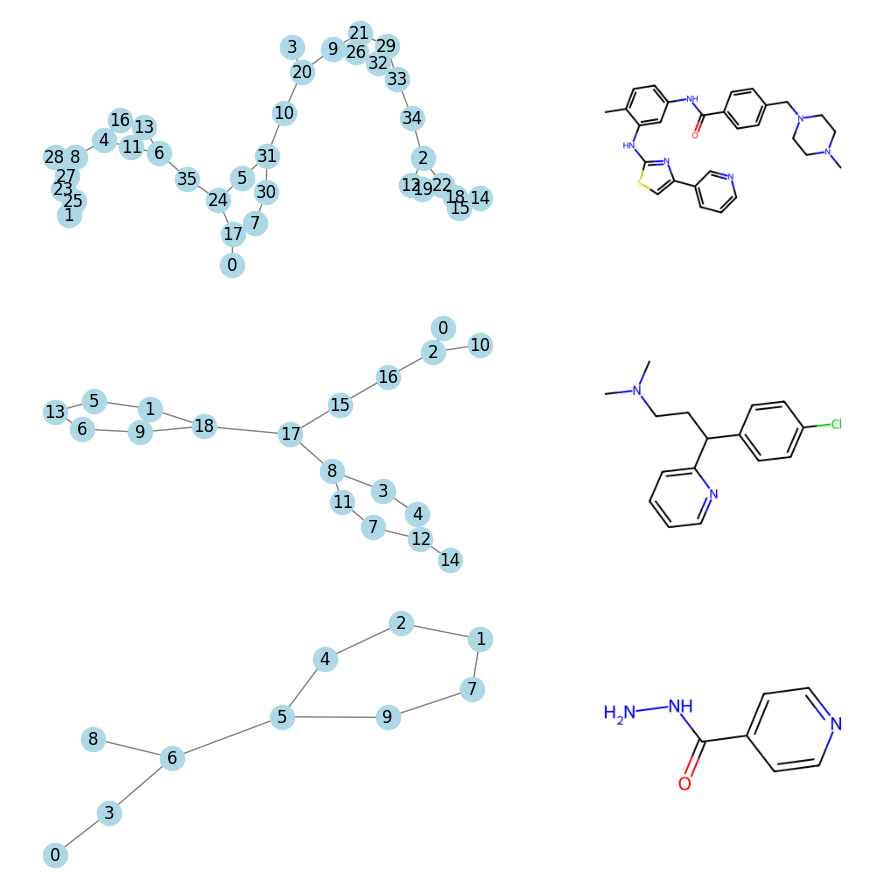

In [68]:
struc_num = 3
data_list = [(dataset[i][0], de_train['SMILES'][i]) for i in np.random.randint(0,len(dataset),struc_num)]


fig, axes = plt.subplots(struc_num, 2, figsize=(10, struc_num * 3))

for idx, (data, smiles) in enumerate(data_list):
    G = nx.Graph()
    for i in range(data.num_nodes):
        G.add_node(i)
    for i, j in data.edge_index.t().tolist():
        G.add_edge(i, j)
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, ax=axes[idx, 0], with_labels=True, node_color='lightblue', edge_color='gray')
    
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(300, 300))
    axes[idx, 1].imshow(PIL.ImageOps.expand(img, border=10, fill='white'))
    axes[idx, 1].axis('off') 

plt.tight_layout()
plt.show()

# Training

In [69]:
from pytorch_lightning.loggers import TensorBoardLogger
class GATModel(L.LightningModule):
    def __init__(self, num_node_features, num_classes, num_cell_types):
        super().__init__()
        self.gat1 = GATConv(num_node_features, 128)
        self.bn1 = BatchNorm(128)
        self.gat2 = GATConv(128, 256)
        self.bn2 = BatchNorm(256)
        self.fc1 = torch.nn.Linear(256 + num_cell_types, 1024)
        self.fc2 = torch.nn.Linear(1024,4096)
        self.fc3 = torch.nn.Linear(4096, num_classes)
        
        self.dropout = torch.nn.Dropout(0.1)
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, data, cell_type):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = torch.cat((x, cell_type), dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        graphs, cell_types, expressions = batch
        preds = self(graphs, cell_types)
        loss = torch.sqrt(torch.nn.functional.mse_loss(preds, expressions))
        batch_size = graphs.num_graphs
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True,batch_size=batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        graphs, cell_types, expressions = batch
        preds = self(graphs, cell_types)
        val_loss = torch.sqrt(torch.nn.functional.mse_loss(preds, expressions))
        batch_size = graphs.num_graphs
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(expressions)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def cal_mrrmse(self, labels, preds):
        labels = labels.numpy()
        preds = preds.numpy()
        score = labels - preds
        score = np.mean(np.sqrt(np.mean(score ** 2, axis=1)))
        return score
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        score = self.cal_mrrmse(all_labels, all_preds)
        print(f'val_MRRMSE:{score}')
        self.val_step_labels.clear()
        self.val_step_outputs.clear()

# モデルのインスタンスを作成
num_node_features = dataset[0][0].num_node_features
num_classes = de_train.iloc[:, 5:].shape[1]
num_cell_types = cell_type_encoded.shape[1]
model = GATModel(num_node_features, num_classes, num_cell_types)
logger = TensorBoardLogger("tb_logs", name="my_model")

# 4. トレーニング
trainer = L.Trainer(max_epochs=15,logger=logger,log_every_n_steps=4)
if not use_val:
    trainer.fit(model, train_loader)
else:
    trainer.fit(model,train_loader,val_dataloaders=val_loader,)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name    | Type      | Params
--------------------------------------
0 | gat1    | GATConv   | 4.2 K 
1 | bn1     | BatchNorm | 256   
2 | gat2    | GATConv   | 33.5 K
3 | bn2     | BatchNorm | 512   
4 | fc1     | Linear    | 269 K 
5 | fc2     | Linear    | 4.2 M 
6 | fc3     | Linear    | 74.6 M


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


# Prediction

In [70]:
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        preds = model(*batch)
        predictions.append(preds)

In [71]:
predict = predictions[0]
predict

tensor([[ 1.8202e-01,  2.4344e-01,  2.3193e-01,  ...,  1.2123e-01,
         -2.5221e-01, -1.1013e-01],
        [ 2.4165e-02,  5.9057e-02,  1.7245e-01,  ...,  7.2157e-02,
         -2.4708e-02, -1.9303e-01],
        [ 6.2453e-04,  2.6917e-02,  1.8475e-01,  ...,  3.6566e-02,
          1.0286e-04, -2.1544e-01],
        ...,
        [ 3.0406e-02,  8.7120e-02,  1.8747e-01,  ...,  7.1210e-02,
         -5.5405e-02, -1.9539e-01],
        [ 2.7835e-02,  2.3903e-02,  1.4653e-01,  ...,  1.1276e-01,
          4.3427e-02, -2.4656e-01],
        [ 1.1923e-02,  6.8361e-02,  1.5973e-01,  ...,  2.8190e-02,
         -6.2848e-02, -1.5819e-01]])

In [72]:
if predict.is_cuda:
    predict = predict.cpu()
sample_sub.iloc[:,1:] = predict.numpy()

In [73]:
sample_sub

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.182020,0.243442,0.231934,0.450232,0.469200,0.688592,-0.003383,0.341589,-0.174806,...,-0.185513,-0.045712,-0.144627,0.050365,0.476650,0.303076,0.122335,0.121228,-0.252210,-0.110133
1,1,0.024165,0.059057,0.172451,0.096812,0.099682,0.100263,-0.072923,0.125662,-0.118137,...,-0.088189,0.041451,-0.137125,0.037631,0.206136,0.115281,0.117086,0.072157,-0.024708,-0.193026
2,2,0.000625,0.026917,0.184749,0.048546,0.056490,0.025134,-0.061985,0.114040,-0.134065,...,-0.067620,0.054783,-0.141121,0.049302,0.180443,0.099487,0.128562,0.036566,0.000103,-0.215444
3,3,0.114670,0.144115,0.148744,0.215769,0.249129,0.405790,-0.029898,0.216165,-0.103078,...,-0.105513,0.002594,-0.089285,0.055958,0.277341,0.195195,0.114015,0.101145,-0.138525,-0.110042
4,4,0.131494,0.159170,0.101987,0.184792,0.270607,0.481165,-0.045847,0.209131,-0.119317,...,-0.098679,-0.021202,-0.076430,0.054102,0.279204,0.186681,0.093078,0.089157,-0.174770,-0.081999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,0.061305,0.131898,0.169862,0.204687,0.217756,0.269051,-0.046122,0.191604,-0.154636,...,-0.129170,0.001899,-0.141059,-0.001911,0.297859,0.165948,0.108012,0.062991,-0.111847,-0.151037
251,251,0.026452,0.039952,0.141800,0.087638,0.089623,0.081810,-0.077613,0.087209,-0.154382,...,-0.077976,-0.002780,-0.121362,-0.002353,0.163456,0.081569,0.074950,0.095441,-0.049475,-0.146115
252,252,0.030406,0.087120,0.187469,0.135246,0.149999,0.144130,-0.076959,0.146802,-0.162375,...,-0.114404,0.016374,-0.168863,-0.002536,0.257003,0.126189,0.106839,0.071210,-0.055405,-0.195393
253,253,0.027835,0.023903,0.146534,-0.027553,0.014650,0.053406,0.016732,0.163971,-0.006311,...,0.007199,0.121554,-0.164152,0.167529,0.170411,0.138903,0.194874,0.112762,0.043427,-0.246555


In [74]:
sample_sub.to_csv('submission.csv',index=False)